# Notebook to make plot comparing fractional contribution low and high metallicities

Code from Ruediger, original plot is by Martyna



In [1]:
import os
import h5py
import numpy as np 
import matplotlib.pyplot as plt
import paths
from pylab import *
import seaborn as sns

from scipy import interpolate

from astropy.table import Table

import astropy.units as u
# from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck18  as cosmo# Planck 2018
from astropy.cosmology import z_at_value

############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD
import importlib
importlib.reload(Z_SFRD)

############################
##PLOT setttings
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


#######################
# Definitions
SOLAR_METALLICITY = 0.0127
outdir = str(paths.data) +'/RuedigerFig2/' #"./"
TNG               = 50
lvl               = 1




In [2]:
def getStellarMassMetallicityTNG():
    fout = outdir + "StellarMassMetallicityTNG%d-%d.hdf5" % (TNG,lvl)
    if os.path.exists( fout ):
        return
  
    print( "Computing data TNG%d" % TNG )

    snap = 99
    s    = gadget_readsnap( snap, snappath=TNGpath, snapbase='snap_', loadonlytype=[5], loadonly=['mass'], chunk=0 )
    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    fname = "%s/snapdir_%03d/snap_%03d.%s.hdf5" % (TNGpath, snap, snap, "%d")
    for ifile in range( s.num_files ):
        with h5py.File(fname % ifile, "r") as f:
            print( "Reading file %d/%d." % (ifile,s.num_files) )

            pStars = f["PartType4"]

            Ages   = pStars["GFM_StellarFormationTime"][:]
            Masses = pStars["GFM_InitialMass"][:].astype('f8')
            Metals = pStars["GFM_Metallicity"][:] / SOLAR_METALLICITY # convert to solar metallicity

        for ir in range(nBinsRedshift):
            i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

            Mass[ir,0] += Masses[i].sum()

            k, = np.where( Metals[i] < 0.1 )
            Mass[ir,1] += Masses[i[k]].sum()

            k, = np.where( Metals[i] > 1.0 )
            Mass[ir,2] += Masses[i[k]].sum()      

    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

def getStellarMassMetallicityIllustris():
    fout = outdir + "StellarMassMetallicityIllustris.hdf5" 
    if os.path.exists( fout ):
        return

    print( "Computing data Illustris" )

    snap = 135
    s    = gadget_readsnap( snap, snappath=IllustrisPath + "Illustris-1/output/", snapbase='snap_', loadonlytype=[5], loadonly=['mass'], chunk=0 )
    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    fname = "%s/Illustris-1/output/snapdir_%03d/snap_%03d.%s.hdf5" % (IllustrisPath, snap, snap, "%d")
    for ifile in range( s.num_files ):
        with h5py.File(fname % ifile, "r") as f:
            print( "Reading file %d/%d." % (ifile,s.num_files) )

            pStars = f["PartType4"]

            Ages   = pStars["GFM_StellarFormationTime"][:]
            Masses = pStars["GFM_InitialMass"][:].astype('f8')
            Metals = pStars["GFM_Metallicity"][:] / SOLAR_METALLICITY # convert to solar metallicity

            for ir in range(nBinsRedshift):
                i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

                Mass[ir,0] += Masses[i].sum()

                k, = np.where( Metals[i] < 0.1 )
                Mass[ir,1] += Masses[i[k]].sum()

                k, = np.where( Metals[i] > 1.0 )
                Mass[ir,2] += Masses[i[k]].sum() 

  
    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

def getStellarMassMetallicitySimba():
    fout = outdir + "StellarMassMetallicitySimba.hdf5" 
    if os.path.exists( fout ):
        return

    print( "Computing data Simba" )

    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    snap  = 151
    fname = "%s/Simba-L100n1000FP/output/snapdir_%03d/snap_%03d.0.hdf5" % (IllustrisPath, snap, snap)
    with h5py.File(fname, "r") as f:
        pStars = f["PartType4"]

    Ages   = pStars["StellarFormationTime"][:]
    Masses = pStars["Masses"][:].astype('f8')
    Metals = pStars["Metallicity"][:][:,2:].sum(axis=1) / SOLAR_METALLICITY # convert to solar metallicity

    for ir in range(nBinsRedshift):
        i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

        Mass[ir,0] += Masses[i].sum()

        k, = np.where( Metals[i] < 0.1 )
        Mass[ir,1] += Masses[i[k]].sum()

        k, = np.where( Metals[i] > 1.0 )
        Mass[ir,2] += Masses[i[k]].sum()      
  
    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

def getStellarMassMetallicityEagle():
    fout = outdir + "StellarMassMetallicityEagle.hdf5" 
    if os.path.exists( fout ):
        return

    print( "Computing data Eagle" )

    snap = 28
    s    = gadget_readsnap( snap, snappath=IllustrisPath + "Eagle-L68n1504FP/output/", snapbase='snap_', loadonlytype=[5], loadonly=['mass'], chunk=0 )
    Mass = np.zeros( (nBinsRedshift,nBinsMetallicity) )

    fname = "%s/Eagle-L68n1504FP/output/snapdir_%03d/snap_%03d.%s.hdf5" % (IllustrisPath, snap, snap, "%d")
    for ifile in range( s.num_files ):
        with h5py.File(fname % ifile, "r") as f:
            print( "Reading file %d/%d." % (ifile,s.num_files) )

            pStars = f["PartType4"]

            Ages   = pStars["GFM_StellarFormationTime"][:]
            Masses = pStars["GFM_InitialMass"][:].astype('f8')
            Metals = pStars["GFM_Metallicity"][:] / SOLAR_METALLICITY # convert to solar metallicity

            for ir in range(nBinsRedshift):
                i, = np.where( Ages >= 1./(1.+redshifts[ir]) )

                Mass[ir,0] += Masses[i].sum()

                k, = np.where( Metals[i] < 0.1 )
                Mass[ir,1] += Masses[i[k]].sum()

                k, = np.where( Metals[i] > 1.0 )
                Mass[ir,2] += Masses[i[k]].sum()      

    with h5py.File(fout, "w") as f:
        f.create_dataset('BinsRedshift', data=redshifts )
        f.create_dataset('Mass', data=Mass )

getStellarMassMetallicityTNG()
getStellarMassMetallicityIllustris()
getStellarMassMetallicitySimba()
getStellarMassMetallicityEagle()



In [3]:
##############################
# Open Simulation data
##############################
with h5py.File(outdir + "StellarMassMetallicityTNG%d-%d.hdf5" % (TNG,lvl), "r") as f:
    TNGBinsRedshift = f["BinsRedshift"][:]
    TNGMass         = f["Mass"][:]

with h5py.File(outdir + "StellarMassMetallicityIllustris.hdf5", "r") as f:
    IllustrisBinsRedshift = f["BinsRedshift"][:]
    IllustrisMass         = f["Mass"][:]

with h5py.File(outdir + "StellarMassMetallicitySimba.hdf5", "r") as f:
    SimbaBinsRedshift = f["BinsRedshift"][:]
    SimbaMass         = f["Mass"][:]

with h5py.File(outdir + "StellarMassMetallicityEagle.hdf5", "r") as f:
    EagleBinsRedshift = f["BinsRedshift"][:]
    EagleMass         = f["Mass"][:]

    
    
##############################
# Read Martyna's data
##############################
def read_Chruslinskadata():
    """
    dataChruslinskaZ01 = [
      [0.17,0.33,0.24,0.43,0.19,0.36],
      [0.09,0.18,0.13,0.27,0.10,0.21,0.12,0.21,0.17,0.31,0.13,0.24],
      [0.03,0.07,0.06,0.15,0.04,0.09,0.02,0.06,0.05,0.14,0.03,0.08]
    ]

    dataChruslinskaZ10 = [
      [0.01,0.19,0.01,0.12,0.01,0.17],
      [0.02,0.27,0.01,0.17,0.02,0.24,0.02,0.26,0.01,0.17,0.02,0.23],
      [0.08,0.55,0.04,0.37,0.07,0.49,0.08,0.55,0.04,0.37,0.06,0.49]
    ]
    """

    dataChruslinska19_Z01 = [[],[],[]]
    dataChruslinska19_Z10 = [[],[],[]]

    dataChruslinska21_Z01 = [[],[],[]]
    dataChruslinska21_Z10 = [[],[],[]]

    for iz in range(3):
        z = ["10.0", "3", "0.5"][iz]
        with open( outdir + "/stellar_mass_fractions_Zsun_Asplund09_zmax_%s.dat" % z, "r" ) as f:
            lines = f.readlines()
            
        for line in lines[1:]:
            Z01 = float(line.split()[2])
            Z10 = float(line.split()[3])

            if line.startswith( "ChN19" ):
                dataChruslinska19_Z01[iz] += [Z01]
                dataChruslinska19_Z10[iz] += [Z10]
            else:
                dataChruslinska21_Z01[iz] += [Z01]
                dataChruslinska21_Z10[iz] += [Z10]

    return dataChruslinska19_Z01, dataChruslinska19_Z10, dataChruslinska21_Z01, dataChruslinska21_Z10

dataChruslinska19_Z01, dataChruslinska19_Z10, dataChruslinska21_Z01, dataChruslinska21_Z10 = read_Chruslinskadata()
print(dataChruslinska19_Z01)


print( "TNG:", TNGMass[:,1] / TNGMass[:,0], TNGMass[:,2] / TNGMass[:,0] )
print( "Illustris:", IllustrisMass[:,1] / IllustrisMass[:,0], IllustrisMass[:,2] / IllustrisMass[:,0] )
print( "Simba:", SimbaMass[:,1] / SimbaMass[:,0], SimbaMass[:,2] / SimbaMass[:,0] )
print( "Eagle:", EagleMass[:,1] / EagleMass[:,0], EagleMass[:,2] / EagleMass[:,0] )




[[13.0, 32.0, 34.0, 53.0], [6.3, 9.1, 20.0, 24.0], [1.9, 1.6, 11.0, 9.6]]
TNG: [0.0225831  0.01040853 0.00147728] [0.61950614 0.6453478  0.72463142]
Illustris: [0.05336877 0.03285365 0.00809697] [0.54760656 0.58140397 0.71122056]
Simba: [0.11930606 0.09686888 0.06116837] [0.34290821 0.36299597 0.37844205]
Eagle: [0.06057463 0.02811677 0.00729037] [0.57598639 0.6316304  0.84622925]


In [5]:
def get_SFRDzZ(redshifts, metals = [], min_logZ_COMPAS = np.log(1e-4), max_logZ_COMPAS = np.log(0.03),
               metal_params = [], SFR_Params = [], min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01): 
    """
    """
    mu_0, mu_z, omega_0, omega_z, alpha = metal_params
    a, b, c, d                          = SFR_Params
    # metallicity distribution
    dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                  omega_0=omega_0, omega_z =omega_z, min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                                  metals = metals ) #np.logspace(-5,1, num=1000)
    
    print('step_logZ', step_logZ, 'min(np.log10(metals))', min(np.log10(metals)), 'max(np.log10(metals))', max(np.log10(metals)))
    # SFR
    sfr        = Z_SFRD.Madau_Dickinson2014(redshifts, a=a, b=b, c=c,  d=d) # Msun year-1 Mpc-3 
    # Combine it into a SFRD
    model_SFRD = (sfr*(dPdlogZ*step_logZ  ).T ).value #step_logZ
    
    return model_SFRD, metallicities

## Load the TNG 100 data

This starformation rate comes from the gas particles in TNG: StarFormationRate = "Instantaneous star formation rate of this gas cell."

See also: 
https://www.tng-project.org/data/docs/specifications/#parttype0

This is why we have to convert the rate to a density by dividing by the co-moving box size. 




In [51]:
interpolate_data = True

##############################################################################
# Load TNG100 data
with h5py.File(paths.data / "SFRMetallicityFromGasTNG100.hdf5", "r") as file:
    MetalBins            = file["MetalBins"][:] #60
    TNG100_center_Zbin   = (MetalBins[:-1] + MetalBins[1:])/2.
    TNG100_Lookbacktimes = file["Lookbacktimes"][:] #100
    BoxSfr               = file["Sfr"][:]
# Convert SFR from sfr/box to sfr cMpc-3
littleh    = 0.6774
Rbox       = 75/littleh
TNG100_SFR = BoxSfr / Rbox**3 *u.Mpc**-3

## The model comes in SFRD/DeltaZ, make sure your data does as well!! 
step_fit_logZ       = np.diff(np.log(MetalBins))[0]    
TNG100_cosmic_SFR   = TNG100_SFR#/step_fit_logZ

## Convert lookback times to redshifts
# the last value of Lookbacktimes = 0, which is problematic for z calculation
TNG100_redshifts = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in TNG100_Lookbacktimes[:-1]] 
TNG100_redshifts.append(0) # put redshift zero back at the end
TNG100_redshifts = np.array(TNG100_redshifts)

#########################################
if interpolate_data:
    #########################################
    # Interpolate the simulation data
    f_interp = interpolate.interp2d(TNG100_Lookbacktimes, TNG100_center_Zbin, TNG100_cosmic_SFR.T, kind='cubic')

    redshift_new         = np.arange(0, 10.1, 0.05)         # Retrieve values at higher res regular intervals
    Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]

    log_TNG100_center_Zbin = np.log10(TNG100_center_Zbin)
    metals_new             = np.logspace(min(log_TNG100_center_Zbin), max(log_TNG100_center_Zbin), int(1e3))

    SFRDnew = f_interp(Lookbacktimes_new,metals_new)

    SFRDnew = SFRDnew.T
    # Original TNG data was in decreasing t_lookback, so reshape your new interpolated thing the same way
    SFRDnew           = SFRDnew[::-1]
    redshift_new      = redshift_new[::-1]
    Lookbacktimes_new = np.array(Lookbacktimes_new[::-1])
    #########################################
    print(50*'*', '\nYou are using the interpolated version')
    # # switch to new interpolated data
    TNG100_cosmic_SFR    = SFRDnew
    TNG100_Lookbacktimes = Lookbacktimes_new
    MetalBins            = metals_new
    TNG100_center_Zbin   = metals_new#(metals_new[:-1] + metals_new[1:])/2.
    TNG100_redshifts     = redshift_new

else:
    print('working with non-interpolated data')
    print('np.shape(TNG100_cosmic_SFR)', np.shape(TNG100_cosmic_SFR))
    
# Checking our interpolation result
# z_i = np.argmin(TNG100_redshifts-0.5)
#     plt.step(np.log10(TNG100_center_Zbin), TNG100_cosmic_SFR[z_i,:], where = 'mid', label = lab)

"""
 We are going to convert SFR to total stellar mass formed
"""
TNG100_centered_SFR       = (TNG100_cosmic_SFR[:-1,:] + TNG100_cosmic_SFR[1:,:])/2.          # Take the SFRD at the center of each bin in lookback time    
TNG100_Lookbacktimes_yr   = TNG100_Lookbacktimes *u.Gyr.to(u.yr)                             # Multiply this by the diff in lookback time to get the total stellar mass formed in each lookback time bin
TNG100_stellarM_formed_dZ = (TNG100_centered_SFR * abs(np.diff(TNG100_Lookbacktimes_yr))[:,np.newaxis])  # This gives us the stellar mass formed at t, per Mpc^-3 per d logZ (it's still 2D)
TNG100_center_redshifts   = (TNG100_redshifts[:-1] + TNG100_redshifts[1:])/2.                 # Take the center of the redshift bins to match the shape of TNG100_stellarM_formed_dZ



************************************************** 
You are using the interpolated version


# Now start plotting the 3-panels

We want to include 

 - Illustris/Simba/TNG50 data
 - Chruslinska 2019, 2021 data
 - TNG 100
 - model fit for TNG 100 
 - Variations of our model fit
 
 


 Working on redshift z < 10
max TNG redshifts 9.975000000000001
total sfr 9095594208.067715
frac highZ sfr 53.47269908103514 frac lowZ sfr 3.2026148998531743 


test_best_fit_parameters.txt
step_logZ 0.02266475149927416 min(np.log10(metals)) -9.908720164658327 max(np.log10(metals)) -0.07538683132499271
(1000, 202) metallicities 1000 redshifts 202
!!!!! max model redshifts 9.975000000000001
np.sum(low_Z) 713 np.sum(high_Z) 185
MartynaLOWZ_best_fit_parameters.txt
step_logZ 0.02266475149927416 min(np.log10(metals)) -9.908720164658327 max(np.log10(metals)) -0.07538683132499271
(1000, 202) metallicities 1000 redshifts 202
!!!!! max model redshifts 9.975000000000001
np.sum(low_Z) 713 np.sum(high_Z) 185
MartynaHIGHZ_best_fit_parameters.txt
step_logZ 0.02266475149927416 min(np.log10(metals)) -9.908720164658327 max(np.log10(metals)) -0.07538683132499271
(1000, 202) metallicities 1000 redshifts 202
!!!!! max model redshifts 9.975000000000001
np.sum(low_Z) 713 np.sum(high_Z) 185

 Working on red

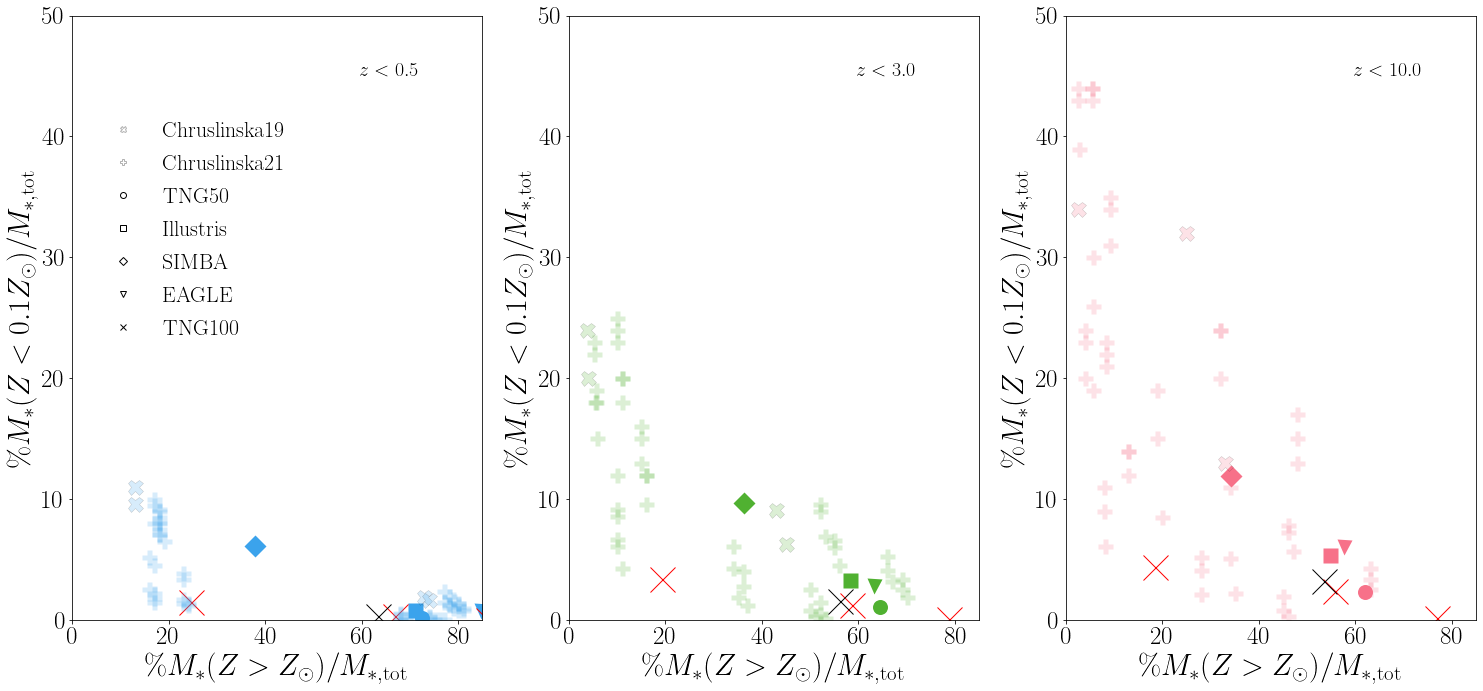

In [50]:
# Now we can make a redshift bool
redshift_points  = [0.5, 3., 10]
redshift_bools   = [TNG100_center_redshifts < redshift_points[2], TNG100_center_redshifts < redshift_points[1], TNG100_center_redshifts < redshift_points[0]]

# And the metallicity boundaries for 'low' and 'high' metallicity
Zsun         = 0.0127 #for TNG
low_metals   = MetalBins < Zsun/10.
high_metals  = MetalBins > Zsun

###########
# Model values
redshifts         = np.arange(0,10.1, 0.05)
center_resh       = (redshifts[:-1] + redshifts[1:])/2.
model_reds_bools  = [center_resh < redshift_points[2], center_resh < redshift_points[1], center_resh < redshift_points[0]]

###########
# Start drawing Figure
f, ax = plt.subplots(figsize = (21,10), sharey=True)

# Remove overall axes to avoid overlap
plt.setp(ax, xticks=[], yticks=[])
ax.axis('off')


colors = sns.husl_palette(3)

######################
# !! We are working from right to left because that's the way the cosmological simulations are set up
# So we'll start plotting the right most plot (z<10) and work to the left
for ir in range(3):
    ###########
    print('\n Working on redshift z <', redshift_points[2-ir])
    
    ###########
    #add first subplot in layout that has 1 row and 3 columns
    axstr   = '13'+str(3-ir) #Reverse order such that lowest z is plotted on left
    subplot = f.add_subplot(int(axstr))
    ax = subplot
    
    ######################
    # Cosmological Simulations
    l, = ax.plot( 100 * TNGMass[ir,2] / TNGMass[ir,0], 100 * TNGMass[ir,1] / TNGMass[ir,0], 'o', mec="None", label=None, color=colors[ir], markersize = 15)
    l, = ax.plot( 100 * IllustrisMass[ir,2] / IllustrisMass[ir,0], 100 * IllustrisMass[ir,1] / IllustrisMass[ir,0], 's', mec="None", color=colors[ir] , markersize = 15)
    l, = ax.plot( 100 * SimbaMass[ir,2] / SimbaMass[ir,0], 100 * SimbaMass[ir,1] / SimbaMass[ir,0], 'D', mec="None", color=colors[ir] , markersize = 15)
    l, = ax.plot( 100 * EagleMass[ir,2] / EagleMass[ir,0], 100 * EagleMass[ir,1] / EagleMass[ir,0], 'v', mec="None", color=colors[ir] , markersize = 15)
    
    # TNG100
    print('max TNG redshifts', max(TNG100_center_redshifts[redshift_bools[ir]] ) )
    sfrd_at_redshift = TNG100_stellarM_formed_dZ[redshift_bools[ir],:]
    TNG100_flowZ     = 100 * np.sum(sfrd_at_redshift[:,low_metals]) /np.sum(sfrd_at_redshift[:,:]) 
    TNG100_fhighZ    = 100 * np.sum(sfrd_at_redshift[:,high_metals]) /np.sum(sfrd_at_redshift) 
    print('total sfr',sum(sfrd_at_redshift))
    print('frac highZ sfr',TNG100_fhighZ, 'frac lowZ sfr',     TNG100_flowZ, '\n\n')
    l, = ax.plot(TNG100_fhighZ, TNG100_flowZ, 'x', c = 'k', markersize = 25, zorder = 10)
    
    ######################
    # Model fits
    # I think it's important that you pick a high num --> small dlogZ 
    # else the metal bools will quickly become inaccurate
    metals        = np.logspace(min(np.log10(MetalBins)), max(np.log10(MetalBins)), num=int(1e3) ) #TNG100_center_Zbin# len(MetalBins)
    # center_metals = (metals[:-1] + metals[1:])/2.
    low_Z         = metals < Zsun/10.
    high_Z        = metals > Zsun
    for fit_param_file in ['test_best_fit_parameters.txt', 'MartynaLOWZ_best_fit_parameters.txt', 'MartynaHIGHZ_best_fit_parameters.txt']:
        print(fit_param_file)
        SzZParams =  Table.read(paths.data / fit_param_file , format = 'csv') # Read in best fit parameters
        # compute the model
        SFRDzZ, metallicities = get_SFRDzZ(redshifts, metals = metals,
                                           metal_params = SzZParams['# mu0','muz','omega0','omegaz','alpha0'][0],
                                           SFR_Params = SzZParams['sf_a','sf_b','sf_c','sf_d'][0])
        print(np.shape(SFRDzZ), 'metallicities', len(metallicities), 'redshifts', len(redshifts))
        #'integrate' your SFR to get Msun formed. Shape SFRDzZ = metal x redshift
        model_centered_SFR       = (SFRDzZ[:,:-1] + SFRDzZ[:,1:])/2.                            # Take the SFR at the center redshifts
        model_t                  = cosmo.lookback_time(redshifts)*u.Gyr.to(u.yr)                # convert z to lookback time
        model_stellarM_formed_dZ = model_centered_SFR * abs(np.diff(model_t))[np.newaxis,:]     # Multiply by dt for tot stellar mass formed in each lookback time bin

        # restrict to all redshifts up to x
        print('!!!!! max model redshifts', max(center_resh[model_reds_bools[ir]]) )
        model_SFRD_uptoz    = model_stellarM_formed_dZ[:,model_reds_bools[ir]]
        print('np.sum(low_Z)', np.sum(low_Z), 'np.sum(high_Z)', np.sum(high_Z) ) 
        lowZfraction        = 100 * np.sum(model_SFRD_uptoz[low_Z,:])/np.sum(model_SFRD_uptoz)  
        highZfraction       = 100 * np.sum(model_SFRD_uptoz[high_Z,:])/np.sum(model_SFRD_uptoz) 
        ax.plot(highZfraction, lowZfraction,'x', c = 'r', markersize = 25)
    
    
    ######################
    # Observations (Chruslinska)
    l, = ax.plot( np.array(dataChruslinska19_Z10[ir]), np.array(dataChruslinska19_Z01[ir]), 'X', mec="k", mew=0.5, color=colors[ir], alpha=0.2 , markersize = 15)
    l, = ax.plot( np.array(dataChruslinska21_Z10[ir]), np.array(dataChruslinska21_Z01[ir]), 'P', mec="None", color=colors[ir], alpha=0.2 , markersize = 15)


    ###########
    # plotvalues
    ax.set_xlabel( "$\% M_* (Z > Z_\odot) / M_\mathrm{*,tot}$" , size =30)
    ax.set_ylabel( "$\% M_* (Z < 0.1 Z_\odot) / M_\mathrm{*,tot}$" , size =30)
    ax.set_ylim( 0, 50. )
    ax.set_xlim( 0, 85. )
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    ax.text(0.7, 0.9, '$z<%3.1f$' % TNGBinsRedshift[ir] , transform = ax.transAxes)

    
###########
# Plot legend in last plot
l, = ax.plot( -1, -1, 'X', alpha=0.3, mfc="None", mec="k" )
l2 = [l]
l, = ax.plot( -1, -1, 'P', alpha=0.3, mfc="None", mec="k" )
l2 += [l]
for m in ['o','s','D','v','x']:
    l, = ax.plot( -1, -1, m, mfc="None", mec="k" )
    l2 += [l]
legend2 = matplotlib.pyplot.legend( l2, ["$\mathrm{Chruslinska19}$", "$\mathrm{Chruslinska21}$","$\mathrm{TNG50}$", "$\mathrm{Illustris}$", "$\mathrm{SIMBA}$", "$\mathrm{EAGLE}$", "$\mathrm{TNG100}$", ], 
                                   frameon=False, numpoints=1, fontsize=22,loc=(0.05,0.45) )#loc=(0.55,0.50) )
# ax.add_artist(legend2)
f.tight_layout()
# f.savefig(str(paths.figures)+ "StellarMassMetallicityTNG%d.pdf" % TNG )
plt.show()



# Testing the fraction of low vs high stellar mass formed in TNG 100

In [8]:

##############################################################################
# Load TNG100 data
with h5py.File(paths.data / "SFRMetallicityFromGasTNG100.hdf5", "r") as f:
    MetalBins         = f["MetalBins"][:] #60
    Obs_center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
    Obs_Lookbacktimes = f["Lookbacktimes"][:] #Gyr
    BoxSfr            = f["Sfr"][:]

print('Obs_Lookbacktimes', np.shape(Obs_Lookbacktimes))
Obs_Lookbacktimes_yr = Obs_Lookbacktimes *u.Gyr.to(u.yr)
# Convert SFR from sfr/box to sfr Mpc-3
littleh = 0.6774
Rbox    = 75/littleh
Obs_cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
Obs_cosmic_SFR = Obs_cosmic_SFR[:-1,:] * abs(np.diff(Obs_Lookbacktimes_yr))[:, np.newaxis]
Obs_cosmic_SFR = Obs_cosmic_SFR.T

# Convert observed lookback times to observed redshifts (lookback times are decreasing, so also obs_redshift is decreasing)
Obs_redshifts     = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Obs_Lookbacktimes[:-1]] 
# Obs_redshifts.insert(len(Obs_redshifts),0) # put redshift zero at the end 
# Obs_redshifts.insert(0,0) # put redshift zero at the end 
Obs_redshifts = np.array(Obs_redshifts)

low_metals   = Obs_center_Zbin < 0.014/10.
high_metals  = Obs_center_Zbin > 0.014
redsh_bools  = [Obs_redshifts < 0.5, Obs_redshifts < 3.0, Obs_redshifts < 10]

for redsh_bool in redsh_bools:
    sfrd_at_redshift = Obs_cosmic_SFR[:,redsh_bool] 

    print('total sfr',sum(sfrd_at_redshift))
    print('frac lowZ sfr', 100 * sum(sfrd_at_redshift[low_metals,:])/sum(sfrd_at_redshift))
    print('frac highZ sfr',100 * sum(sfrd_at_redshift[high_metals,:])/sum(sfrd_at_redshift), '\n\n')

    

Obs_Lookbacktimes (100,)
total sfr 98329020.62080646 1 / Mpc3
frac lowZ sfr 0.40731281328927427
frac highZ sfr 56.10776868331118 


total sfr 461298223.3006129 1 / Mpc3
frac lowZ sfr 1.9375302875412836
frac highZ sfr 49.41060557337239 


total sfr 538758224.9672195 1 / Mpc3
frac lowZ sfr 3.8094241279245202
frac highZ sfr 46.81113164450891 




In [2]:

# Only xneeded when reading snapshots directly (not here)
# TNGpath           = "/virgo/simulations/IllustrisTNG/TNG%d-%d/output/" % (TNG,lvl)
# TNGVariationsPath = "/isaac/ptmp/gc/apillepi/sims.TNG_method/"
# IllustrisPath     = "/virgo/simulations/Illustris/"
redshifts        = [10., 3., 0.5]
nBinsRedshift    = len(redshifts)
nBinsMetallicity = 3



#SOLAR_METALLICITY = 0.02
#outdir = "./ZSOL002/"


In [6]:

redshifts = np.arange(0,10.1, 0.1)#np.array([0.5, 3, 10])
metals    = np.logspace(-10, 1, num=100)

# Read in best fit parameters
SzZParams =  Table.read(paths.data / 'test_best_fit_parameters.txt', format = 'csv')

# Compute the SFRD(z,Z)
SFRDzZ, metallicities = get_SFRDzZ(redshifts, metals = metals,
                                       metal_params = SzZParams['# mu0','muz','omega0','omegaz','alpha0'][0],
                                       SFR_Params = SzZParams['sf_a','sf_b','sf_c','sf_d'][0])
# SFRDzZ = return_ZdepSFRD()
# print(SFRDzZ, np.shape(SFRDzZ))

Zsun = 0.014
low_Z  = metals < Zsun/10
high_Z = metals > Zsun

redshift_points = [0.5, 3., 10]
low_redshift    = redshifts <= redshift_points[0]
medium_redshift = redshifts <= redshift_points[1]
high_redshift   = redshifts <= redshift_points[2]

# Compute the total star formation mass up to some redshift
# And the fraction of that mass being high vs low metallicity
redshift_bools  = [low_redshift, medium_redshift, high_redshift]
for i, z_bool in enumerate(redshift_bools):
    SFRD_uptoz = SFRDzZ[:,z_bool]
    print('redshift: ', redshift_points[i])
    print('tot SFRD:', sum(SFRD_uptoz))

    print('low Z sfrd:', sum(SFRD_uptoz[low_Z,:]))
    print('fration at low Z', 100 * sum(SFRD_uptoz[low_Z,:])/sum(SFRD_uptoz), '%')

    print('high Z sfrd: ', sum(SFRD_uptoz[high_Z,:]) )
    print('fration at high Z', 100 * sum(SFRD_uptoz[high_Z,:])/sum(SFRD_uptoz), '%', '\n\n')


redshift:  0.5
tot SFRD: 0.14148487007046695
low Z sfrd: 0.0006721201749127952
fration at low Z 0.4750473846270939 %
high Z sfrd:  0.08619056231513073
fration at high Z 60.918571909634764 % 


redshift:  3.0
tot SFRD: 1.8488164277821797
low Z sfrd: 0.049893467934419664
fration at low Z 2.6986707379202235 %
high Z sfrd:  0.8848843148101624
fration at high Z 47.86220532839272 % 


redshift:  10
tot SFRD: 3.627051046323752
low Z sfrd: 0.32777162298752094
fration at low Z 9.036862696480062 %
high Z sfrd:  1.4090706305012302
fration at high Z 38.84893299005023 % 




In [4]:
redshifts         = np.arange(0,10.1, 0.05)
center_resh       = (redshifts[:-1] + redshifts[1:])/2.

metals        = np.logspace(min(np.log10(MetalBins)), max(np.log10(MetalBins)), num=int(1e4) ) #TNG100_center_Zbin# len(MetalBins)
# center_metals = (metals[:-1] + metals[1:])/2.
low_Z         = metals < Zsun/10.
high_Z        = metals > Zsun

###########
# Model values
SzZParams =  Table.read(paths.data / 'test_best_fit_parameters.txt', format = 'csv') # Read in best fit parameters
mu_0, mu_z, omega_0, omega_z, alpha = SzZParams['# mu0','muz','omega0','omegaz','alpha0'][0]
a, b, c, d                          = SzZParams['sf_a','sf_b','sf_c','sf_d'][0]
# metallicity distribution
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                Z_SFRD.skew_metallicity_distribution(redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                              omega_0=omega_0, omega_z =omega_z, min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals = metals ) #np.logspace(-5,1, num=1000)

print('step_logZ', step_logZ, 'min(np.log10(metals))', min(np.log10(metals)), 'max(np.log10(metals))', max(np.log10(metals)))
print('np.shape(dPdlogZ)', np.shape(dPdlogZ), 'np.shape(metals)',np.shape(metals), 'np.shape(redshifts)', np.shape(redshifts))
# print('metals',metals)
print('metals[low_Z]',max(metals[low_Z]), Zsun/10., max(metals[low_Z]) - Zsun/10.)
print('sum (dPdlogZ[low_Z Z]*step_logZ)', np.sum(dPdlogZ[0,low_Z]*step_logZ, axis = -1))

print('metals[high_Z]',min(metals[high_Z]), Zsun, min(metals[high_Z]) - Zsun)
print('sum (dPdlogZ[high Z]*step_logZ)', np.sum(dPdlogZ[0,high_Z]*step_logZ, axis = -1))



NameError: name 'MetalBins' is not defined

# Checking that the interpolation does what it should:


working with non-interpolated data
np.shape(TNG100_cosmic_SFR) (100, 60)
!!!!! min(TNG100_center_Zbin[high_metals]) 0.018111169788269727 = 0.0127
max(TNG100_center_Zbin[low_metals]) 0.0012338996338110337  =  0.0012699999999999999

max TNG redshifts 9.48400988300791
np.shape(sfrd_at_redshift) (60,)
537006787.2769041 1 / Mpc3
total sfr 537006787.2769041 1 / Mpc3
frac highZ sfr 46.920092723930324 frac lowZ sfr 3.739012826823664 



max TNG redshifts 2.9710989346783534
np.shape(sfrd_at_redshift) (60,)
463363625.7194335 1 / Mpc3
total sfr 463363625.7194335 1 / Mpc3
frac highZ sfr 49.40521244310451 frac lowZ sfr 1.9510197285376103 



max TNG redshifts 0.4926001738852824
np.shape(sfrd_at_redshift) (60,)
101578511.37820712 1 / Mpc3
total sfr 101578511.37820712 1 / Mpc3
frac highZ sfr 56.104046763166046 frac lowZ sfr 0.40840513184032406 


************************************************** 
You are doing the interpolated version
np.shape(TNG100_cosmic_SFR) (202, 500)
!!!!! min(TNG100_center_Zb

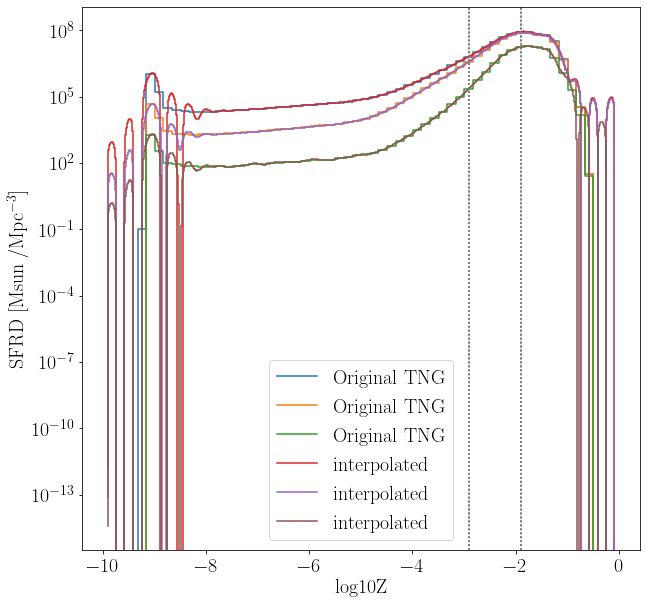

In [319]:
##############################################################################
# Load TNG100 data
with h5py.File(paths.data / "SFRMetallicityFromGasTNG100.hdf5", "r") as file:
    MetalBins            = file["MetalBins"][:] #60
    TNG100_center_Zbin   = (MetalBins[:-1] + MetalBins[1:])/2.
    TNG100_Lookbacktimes = file["Lookbacktimes"][:] #100
    BoxSfr               = file["Sfr"][:]
# Convert SFR from sfr/box to sfr cMpc-3
littleh    = 0.6774
Rbox       = 75/littleh
TNG100_SFR = BoxSfr / Rbox**3 *u.Mpc**-3

## The model comes in SFRD/DeltaZ, make sure your data does as well!! 
step_fit_logZ       = np.diff(np.log(MetalBins))[0]    
TNG100_cosmic_SFR   = TNG100_SFR#/step_fit_logZ

## Convert lookback times to redshifts
# the last value of Lookbacktimes = 0, which is problematic for z calculation
TNG100_redshifts = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in TNG100_Lookbacktimes[:-1]] 
TNG100_redshifts.append(0) # put redshift zero back at the end
TNG100_redshifts = np.array(TNG100_redshifts)

#########################################
# Interpolate the simulation data
f_interp = interpolate.interp2d(TNG100_Lookbacktimes, TNG100_center_Zbin, TNG100_cosmic_SFR.T, kind='cubic')

redshift_new         = np.arange(0, 10.1, 0.05)         # Retrieve values at higher res regular intervals
Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]

log_TNG100_center_Zbin = np.log10(TNG100_center_Zbin)
metals_new             = np.logspace(min(log_TNG100_center_Zbin), max(log_TNG100_center_Zbin), 500)

SFRDnew = f_interp(Lookbacktimes_new,metals_new)

SFRDnew = SFRDnew.T
# Original TNG data was in decreasing t_lookback, so reshape your new interpolated thing the same way
SFRDnew           = SFRDnew[::-1]
redshift_new      = redshift_new[::-1]
Lookbacktimes_new = np.array(Lookbacktimes_new[::-1])
#########################################
# First we need to convert observed lookback times to observed redshifts 
# (lookback times are decreasing, so also TNG100_redshift is decreasing)

#########################################
fig, ax = plt.subplots(figsize = (10,10) )
for i in range(2):
    if i  == 0:
        print('working with non-interpolated data')
        lab = 'Original TNG'
        print('np.shape(TNG100_cosmic_SFR)', np.shape(TNG100_cosmic_SFR))
        
    else:
        print(50*'*', '\nYou are doing the interpolated version')
        # # switch to new interpolated data
        TNG100_cosmic_SFR    = SFRDnew
        TNG100_Lookbacktimes = Lookbacktimes_new
        MetalBins            = metals_new
        TNG100_center_Zbin   = metals_new#(metals_new[:-1] + metals_new[1:])/2.
        TNG100_redshifts     = redshift_new
        
        lab = 'interpolated'
        print('np.shape(TNG100_cosmic_SFR)', np.shape(SFRDnew))
    
    # Checking our interpolation result
    z_i = np.argmin(TNG100_redshifts-0.5)
#     plt.step(np.log10(TNG100_center_Zbin), TNG100_cosmic_SFR[z_i,:], where = 'mid', label = lab)
    
    """
     We are going to convert SFR to total stellar mass formed
    """
    TNG100_centered_SFR       = (TNG100_cosmic_SFR[:-1,:] + TNG100_cosmic_SFR[1:,:])/2.          # Take the SFRD at the center of each bin in lookback time    
    TNG100_Lookbacktimes_yr   = TNG100_Lookbacktimes *u.Gyr.to(u.yr)                             # Multiply this by the diff in lookback time to get the total stellar mass formed in each lookback time bin
    TNG100_stellarM_formed_dZ = (TNG100_centered_SFR * abs(np.diff(TNG100_Lookbacktimes_yr))[:,np.newaxis])  # This gives us the stellar mass formed at t, per Mpc^-3 per d logZ (it's still 2D)
    TNG100_center_redshifts  = (TNG100_redshifts[:-1] + TNG100_redshifts[1:])/2.                 # Take the center of the redshift bins to match the shape of TNG100_stellarM_formed_dZ

    redshift_points  = [0.5, 3., 10]                                                             # Now we can make a redshift bool
    redshift_bools   = [TNG100_center_redshifts < redshift_points[2], TNG100_center_redshifts < redshift_points[1], TNG100_center_redshifts < redshift_points[0]]

    Zsun         = 0.0127 #for TNG                                                               # And the metallicity boundaries for 'low' and 'high' metallicity
    low_metals   = TNG100_center_Zbin < Zsun/10.
    high_metals  = TNG100_center_Zbin > Zsun
    print('!!!!! min(TNG100_center_Zbin[high_metals])', min(TNG100_center_Zbin[high_metals]), '=', Zsun )
    print('max(TNG100_center_Zbin[low_metals])', max(TNG100_center_Zbin[low_metals]), ' = ', Zsun/10.)

    
    for ir in range(len(redshift_bools)):
        
        print('\nmax TNG redshifts', max(TNG100_center_redshifts[redshift_bools[ir]] ) )
        sfrd_at_redshift = np.sum(TNG100_stellarM_formed_dZ[redshift_bools[ir],:], axis = 0) # Sum over all redshifts
        
        plt.step(np.log10(TNG100_center_Zbin), np.sum(TNG100_stellarM_formed_dZ[redshift_bools[ir],:], axis = 0), where = 'mid', label = lab)
        plt.axvline(x= np.log10(Zsun/10.), color = 'grey', ls =':'  )
        plt.axvline(x= np.log10(Zsun), color = 'grey', ls =':'  ) 
        
        print('np.shape(sfrd_at_redshift)', np.shape(sfrd_at_redshift))
        print(np.sum(sfrd_at_redshift))
        TNG100_flowZ     = 100 * np.sum(sfrd_at_redshift[low_metals]) /np.sum(sfrd_at_redshift)
        TNG100_fhighZ    = 100 * np.sum(sfrd_at_redshift[high_metals]) /np.sum(sfrd_at_redshift) 
        print('total sfr',sum(sfrd_at_redshift))
        print('frac highZ sfr',TNG100_fhighZ, 'frac lowZ sfr',     TNG100_flowZ, '\n\n') 

        
plt.xlabel('log10Z')
# plt.xlim(-5, 1)
plt.yscale('log')
plt.ylabel('SFRD [Msun /Mpc$^{-3}$]')
plt.legend()
plt.show()







